In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

In [7]:
df = pd.read_json('/kaggle/input/dataset/News_Category_Dataset_v2.json', lines = True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [8]:
# WORLDPOST and THE WORLDPOST were given as two separate categories in the dataset. Here I change the category THE WORLDPOST to WORLDPOST
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [9]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 40 unique categories


In [10]:
df.groupby('category').size()

category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int64

In [11]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

In [12]:
#since I am using bert-large-uncased as the model, I am converting each of the news headlines and descriptions into lower case.
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())

In [13]:
#calculating the length of headlines and descriptions
df['descr_len'] = df['short_description'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))

In [14]:
df.describe()

,date,categoryEncoded,descr_len,headline_len
count,200853,200853.000000,200853.000000,200853.000000
mean,2015-02-06 05:55:12.542008576,22.024366,19.728289,9.538563
min,2012-01-28 00:00:00,0.000000,0.000000,0.000000
25%,2013-07-18 00:00:00,13.000000,10.000000,7.000000
50%,2015-01-25 00:00:00,24.000000,19.000000,10.000000
75%,2016-08-19 00:00:00,30.000000,24.000000,12.000000
max,2018-05-26 00:00:00,39.000000,243.000000,44.000000
std,NaN,10.753991,14.409189,3.089320


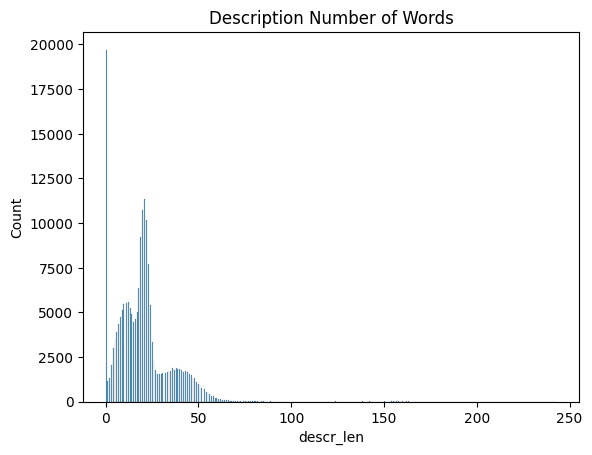

In [15]:
sns.histplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

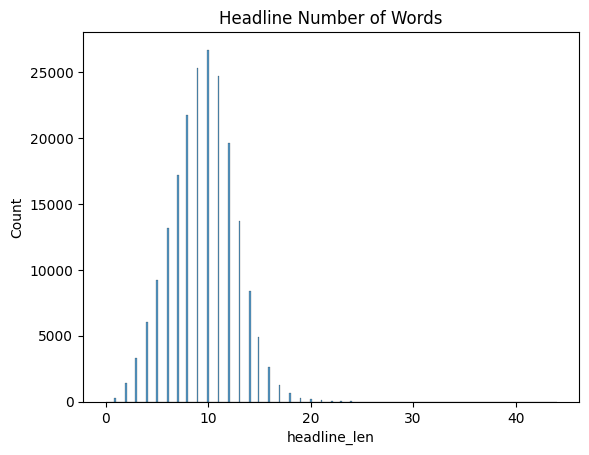

In [16]:
sns.histplot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()

As we can see, that there are a lot of samples that have a description length of 0, however almost all articles have a headline. Going with the intuition that the headline is often more descriptive of the category of the news, as well as to provide more text data to the model, I add news headlines to the short description and modify the description of the news samples.

In [17]:
df['short_description'] = df['headline'] + df['short_description']

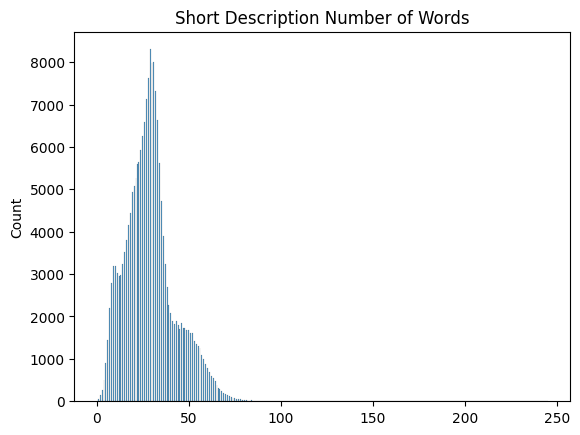

In [18]:
sns.histplot(df['headline_len'] + df['descr_len'])
plt.title('Short Description Number of Words')
plt.show()

In [19]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer(
        texts,
        return_attention_mask=False,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        max_length=maxlen
    )

    return np.array(enc_di['input_ids'])

In [20]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [21]:
X_train,X_test ,y_train,y_test = train_test_split(df['short_description'], df['categoryEncoded'], random_state = 42, test_size = 0.3)

In [22]:
# tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str').tolist(), tokenizer, maxlen=80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=40,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str').tolist(), tokenizer, maxlen=80)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=40,dtype = 'int32')

In [23]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40.
    out = tf.keras.layers.Dense(40, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [24]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=80)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 80)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             80, 1024),                          
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [25]:
#creating the training and testing dataset.
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
#training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10
549/549 [==============================] - 155s 283ms/step - loss: 1.0006 - accuracy: 0.6977
Epoch 2/10
549/549 [==============================] - 155s 283ms/step - loss: 0.8400 - accuracy: 0.7396
Epoch 3/10
549/549 [==============================] - 155s 283ms/step - loss: 0.6918 - accuracy: 0.7833
Epoch 4/10
504/549 [==========================>...] - ETA: 12s - loss: 0.5503 - accuracy: 0.8222

# Evaluation

In [27]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
#converting the one hot vector output to a linear numpy array.
pred_classes = np.argmax(preds, axis = 1)

2023-09-06 11:47:55.050106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-06 11:47:55.432533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


236/236 [==============================] - 48s 120ms/step


In [28]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [29]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
56274,shooting rampage results in 'mass casualties' ...,CRIME,QUEER VOICES
9929,"donald trump lashes out at cnn, abc over repor...",POLITICS,MEDIA
163271,model kate moss walks louis vuitton rtw fall 2...,STYLE & BEAUTY,STYLE & BEAUTY
190013,7 ways single moms cope with loneliness“am i t...,DIVORCE,DIVORCE
13564,sen. sherrod brown: steve bannon 'is a white s...,POLITICS,POLITICS


In [30]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.6863050982474774


In [31]:
result_df.to_csv('testPredictions.csv', index = False)

# Confusion Matrix

In [32]:
result_df[result_df['true_category']!=result_df['predicted_category']]

,description,true_category,predicted_category
56274,shooting rampage results in 'mass casualties' ...,CRIME,QUEER VOICES
9929,"donald trump lashes out at cnn, abc over repor...",POLITICS,MEDIA
90378,the roots aim to expand music festival followi...,BLACK VOICES,ENTERTAINMENT
136467,10 cities that could run out of water - weathe...,ENVIRONMENT,GREEN
50945,trevor noah explains why donald trump is reall...,POLITICS,COMEDY
...,...,...,...
130652,when men were menafter the rich incognito scan...,SPORTS,QUEER VOICES
66731,these graphic novel authors illustrate the str...,WORLDPOST,QUEER VOICES
118907,"professor slammed to the ground by police, arr...",COLLEGE,CRIME
77550,parents arrested after 19-year-old dies in chu...,RELIGION,CRIME


In [33]:
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

<Axes: >

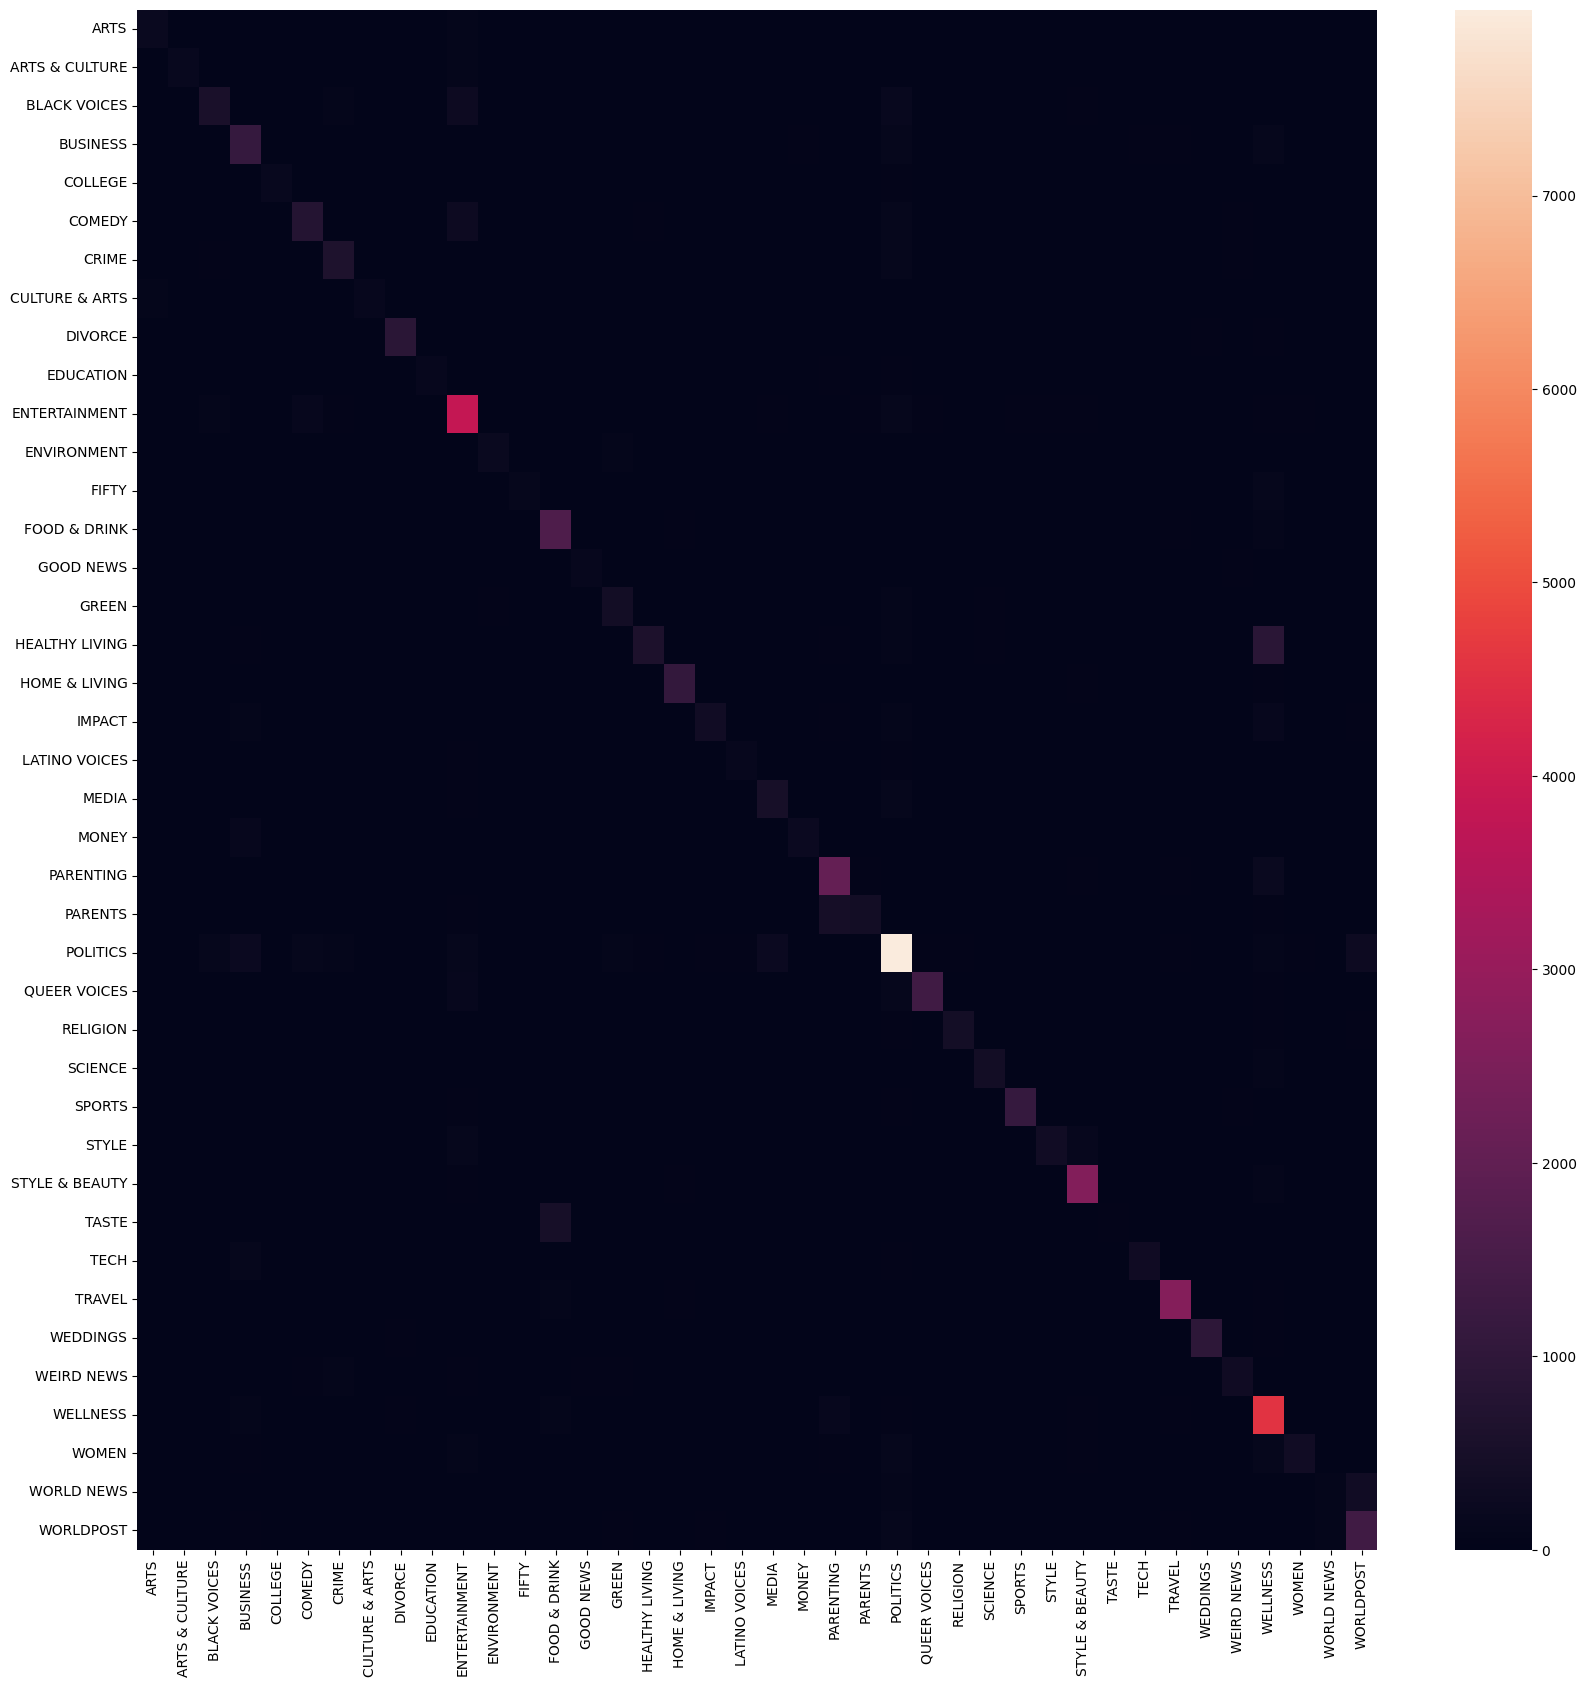

In [34]:
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_cm)